In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from cnn_utils import *
from sklearn import neighbors, metrics, model_selection
import os
import cv2
import numpy as np
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
np.random.seed(1)

#### Vamos a redimensionar las imagenes a 820x615, ya que al tenerlas en alta resolucion, gastamos demasiados recursos

In [67]:
RUTA_AUX = 'Datasets/ALL_IDB_Dataset_1/ALL_IDB1/im/'
IMAGE_ID_NAME = os.listdir(RUTA_AUX)

X = []
y = []

'''
Formatos de Imagenes que tenemos dentro de la carpeta /Imagenes_Resultados/Imagenes_Resize/Imagenes_Resize_WIDTHxHEIGHT:

    - 2592x1944 (100.00% de resolucion)
    - 1944x1458 (75.00% de resolucion)
    - 1458x1093 (56.25% de resolucion)
    - 1093x820  (42.16% de resolucion)
    - 820x615   (31.63% de resolucion)
    - 615x461   (23.72% de resolucion)
'''

# Tenemos que cargar nuestras imagenes sin tratar y crear los conjuntos X (imagenes en pixeles) e Y (clases 0 o 1)
for image in range(len(IMAGE_ID_NAME)):
    X.append(cv2.imread('Imagenes_Resultados/Imagenes_Resize/Imagenes_Resize_615x461/' + IMAGE_ID_NAME[image]))
    
    # Guardamos el identificador de la imagen correspondiente
    NAME = IMAGE_ID_NAME[image]
    y.append(int(NAME.split('.')[0].split('_')[1]))

    
X = np.array(X)
y = np.array(y) 

# Creamos los grupos de entrenamiento y de test
X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = model_selection.train_test_split(X, y, train_size=0.7)
classes = np.array(['Sano', 'Leucemia'])



#### Vamos a mostrar 5 de nuestras 75 muestras de entrenamiento

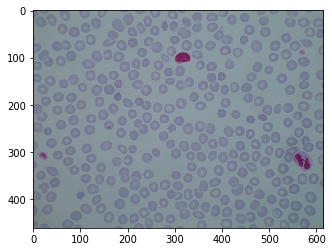

y = 0


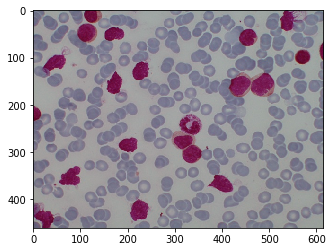

y = 1


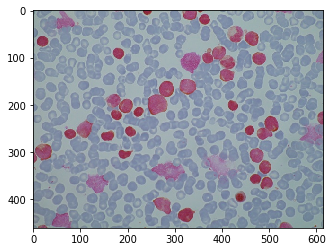

y = 1


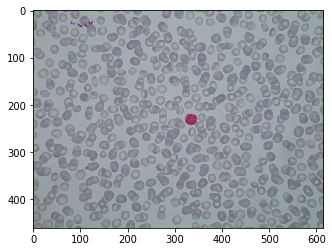

y = 0


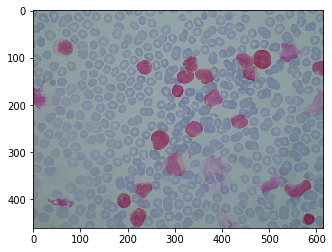

y = 1


In [68]:
for i in range(5):
    plt.imshow(X_train_orig[i])
    plt.show()
    print ("y = " + str(np.squeeze(Y_train_orig[i])))

#### Normalizamos los valores para acelerar el proceso 

In [69]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 2).T
Y_test = convert_to_one_hot(Y_test_orig, 2).T
print ("Cantidad de muestras de entrenamiento = " + str(X_train.shape[0]))
print ("Cantidad de muestras de test = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

Cantidad de muestras de entrenamiento = 75
Cantidad de muestras de test = 33
X_train shape: (75, 461, 615, 3)
Y_train shape: (75, 2)
X_test shape: (33, 461, 615, 3)
Y_test shape: (33, 2)


#### El objeto placeholder se usa para agregar datos externos dentro de un Objeto Graph, pero los datos a agregar no se agregan al crear el placeholder, para ello se usa la inicialización de las variables

In [70]:
### GRADED FUNCTION: create_placeholders

def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """

    X = tf.placeholder(tf.float32, [None, n_H0, n_W0, n_C0])
    Y = tf.placeholder(tf.float32, [None, n_y])
    
    return X, Y


X, Y = create_placeholders(461, 615, 3, 2)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("Placeholder_2:0", shape=(?, 461, 615, 3), dtype=float32)
Y = Tensor("Placeholder_3:0", shape=(?, 2), dtype=float32)


#### Funcion para inicializar los pesos

In [71]:
# GRADED FUNCTION: initialize_parameters

def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [4, 4, 3, 8]
                        W2 : [2, 2, 8, 16]
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """
    
    tf.set_random_seed(1)                              # so that your "random" numbers match ours
        
    W1 = tf.get_variable("W1", [4, 4, 3, 8], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2", [2, 2, 8, 16], initializer=tf.contrib.layers.xavier_initializer(seed=0))

    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters


tf.reset_default_graph()
with tf.Session() as sess_test:
    parameters = initialize_parameters()
    init = tf.global_variables_initializer()
    sess_test.run(init)
    print("W1 = " + str(parameters["W1"].eval()[1,1,1]))
    print("W2 = " + str(parameters["W2"].eval()[1,1,1]))

W1 = [ 0.00131723  0.1417614  -0.04434952  0.09197326  0.14984085 -0.03514394
 -0.06847463  0.05245192]
W2 = [-0.08566415  0.17750949  0.11974221  0.16773748 -0.0830943  -0.08058
 -0.00577033 -0.14643836  0.24162132 -0.05857408 -0.19055021  0.1345228
 -0.22779644 -0.1601823  -0.16117483 -0.10286498]


In [73]:
# GRADED FUNCTION: forward_propagation

def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X, W1, strides=[1, 1, 1, 1], padding='SAME')
    
    # RELU
    A1 = tf.nn.relu6(Z1)
    
    # MAXPOOL: window 8x8, stride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize = [1, 8, 8, 1], strides = [1, 8, 8, 1], padding='SAME')
    
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1, W2, strides=[1, 1, 1, 1], padding='SAME')
    
    # RELU
    A2 = tf.nn.relu6(Z2)
    
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2, ksize = [1, 4, 4, 1], strides = [1, 4, 4, 1], padding='SAME')
    
    # FLATTEN
    P = tf.contrib.layers.flatten(P2)
    
    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 6 neurons in output layer. Hint: one of the arguments should be "activation_fn=None" 
    Z3 = tf.contrib.layers.fully_connected(P, 2, activation_fn=None)

    return Z3


tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(461, 615, 3, 2)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(Z3, {X: np.random.randn(2,461, 615,3), Y: np.random.randn(2,2)})
    print("\n\n\nZ3 = " + str(a))




Z3 = [[-2.2781255  1.2023457]
 [-2.0141397  1.3000929]]


In [74]:
# GRADED FUNCTION: compute_cost 

def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (2, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3, labels=Y))
    
    return cost


tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(1458, 1944, 3, 2)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(cost, {X: np.random.randn(4,1458, 1944,3), Y: np.random.randn(4,2)})
    print("\n\n\ncost = " + str(a))




cost = 0.9614468


In [76]:
# GRADED FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, learning_rate=0.001,
          num_epochs=100, minibatch_size=12, print_cost=True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- test set, of shape (None, n_y = 6)
    X_test -- training set, of shape (None, 64, 64, 3)
    Y_test -- test set, of shape (None, n_y = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of the correct shape
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)

    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})
                
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

Cost after epoch 0: 0.853545
Cost after epoch 5: 0.773964
Cost after epoch 10: 0.668317
Cost after epoch 15: 0.444042
Cost after epoch 20: 0.180182
Cost after epoch 25: 0.088522
Cost after epoch 30: 0.055480
Cost after epoch 35: 0.084907
Cost after epoch 40: 0.015156
Cost after epoch 45: 0.007943
Cost after epoch 50: 0.004480
Cost after epoch 55: 0.003440
Cost after epoch 60: 0.002599
Cost after epoch 65: 0.002255
Cost after epoch 70: 0.001939
Cost after epoch 75: 0.002338
Cost after epoch 80: 0.001403
Cost after epoch 85: 0.001242
Cost after epoch 90: 0.001068
Cost after epoch 95: 0.000955


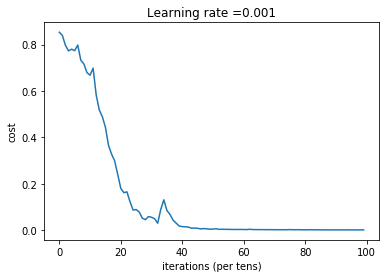

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 1.0
Test Accuracy: 1.0


In [77]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)